### ライブラリ

In [29]:
import time
from functools import partial
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### データセットの準備

In [7]:
# 前処理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# データのロード
train_data = torchvision.datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transform)
val_data = torchvision.datasets.MNIST(root="./mnist_data", train=False, download=True, transform=transform)

# データローダー
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### モデルの定義

In [9]:
# CNN
def get_conv_model():
    return nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(4),   # Batch Normalization
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),   # Batch Normalization
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # Batch Normalization
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),  # Batch Normalization
    nn.ReLU(),
    # 32x2x2
    nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
    # 32x1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10)
    # 10
)

In [ ]:
# CNN
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [ ]:
# モデルのインスタンス化
conv_model = get_conv_model()

# モデルの確認
for name, module in conv_model.named_modules():
    print(name, module)

In [ ]:
# 重みの初期化
for layer in conv_model:
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        init.kaiming_normal_(layer.weight)

In [28]:
# forward hook
class ActivationStatistics:
    """
    Activationの平均、標準偏差を保存するクラス
    """

    def __init__(self, model):
        self.model = model
        # ReLUの出力の平均、標準偏差を保存するリストを動的に作成
        self.act_means = [[] for module in model if isinstance(module, nn.ReLU)]
        self.act_stds = [[] for module in model if isinstance(module, nn.ReLU)]
        self.register_hook()
    
    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, module in enumerate(relu_layers):
            module.register_forward_hook(partial(self.save_out_stats, i))
    
    def save_out_stats(self, i, module, input, output):
        self.act_means[i].append(output.detach().mean().item())   # detach()で勾配情報を削除(計算グラフから切り離す)
        self.act_stds[i].append(output.detach().std().item())
    
    def get_statistics(self):
        return self.act_means, self.act_stds
    
    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(20, 5))

        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title("Activation Means")
        axs[0].legend(range(len(self.act_means)))

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title("Activation Stds")
        axs[1].legend(range(len(self.act_stds)))

        plt.show()

In [11]:
# optimizer
opt = optim.Adam(conv_model.parameters(), lr=0.03, weight_decay=0.001)   # weight_decay: L2正則化

### 学習

In [13]:
start = time.time()
#train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)
end = time.time()
print(end - start)

epoch: 0: train error: 2.2988436837186184, validation error: 2.290087684800353, validation accuracy: 0.11817642405063292


epoch: 1: train error: 1.6490511291189742, validation error: 0.4326843857010709, validation accuracy: 0.8620450949367089


epoch: 2: train error: 0.3344749953828132, validation error: 0.29738517242330537, validation accuracy: 0.9052610759493671


epoch: 3: train error: 0.2324569842327378, validation error: 0.21527942923145205, validation accuracy: 0.9311708860759493


epoch: 4: train error: 0.1865339554242615, validation error: 0.158523970825857, validation accuracy: 0.9515427215189873
48.29191875457764


### 学習曲線のプロット

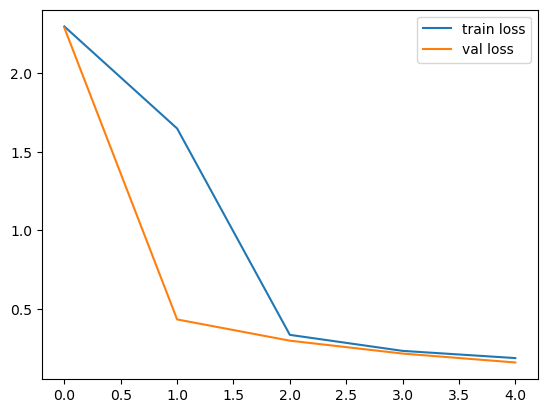

In [15]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()